# The following dataset is used: [Weather Dataset - Rattle Package](https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package). The objective is to build a model using a neural network to predict if it will rain the next day.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, accuracy_score, f1_score, recall_score, precision_score, mean_absolute_error
from sklearn.preprocessing import KBinsDiscretizer, MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from scipy import stats
import torch
import torch.nn as nn
from torch.utils import data as data_utils
import warnings

warnings.filterwarnings("ignore")

file = "https://raw.githubusercontent.com/Mafasamo/PortafolioML/refs/heads/main/Neural%20Network/weatherAUS.csv"

raw_data = pd.read_csv(file)
raw_data.head(5)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


## Preprocessing:

Dataset information:

In [2]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

It is verified if any null values exist in the data.

In [3]:
total_nulls = raw_data.isnull().sum().sum()
print("Total number of null values in the DataFrame:", total_nulls)

Total number of null values in the DataFrame: 343248


Rows with null values in the target feature, corresponding to 2.24% of the total rows, are removed.

In [4]:
null_percentage = raw_data.isnull().mean() * 100

target_null_percentage = null_percentage['RainTomorrow']
print("Percentage of null values in the target feature (RainTomorrow):", target_null_percentage)

raw_data = raw_data[(raw_data["RainTomorrow"] == "Yes") | (raw_data["RainTomorrow"] == "No")]
raw_data["RainTomorrow"].replace({"No": 0, "Yes": 1}, inplace=True)

raw_data["RainToday"].replace({"No": 0, "Yes": 1}, inplace=True)

Percentage of null values in the target feature (RainTomorrow): 2.245978275814657


Analysis of the percentage of null values for each feature.

In [5]:
print("Percentage of null values per feature:")
print(null_percentage)

# Drop 'RainTomorrow' from null percentage as it's already handled
null_percentage = null_percentage.drop('RainTomorrow')

# Separate target feature and drop from raw data
target = raw_data[['RainTomorrow']].copy()
raw_data = raw_data.drop(["RainTomorrow"], axis=1)

Percentage of null values per feature:
Date              0.000000
Location          0.000000
MinTemp           1.020899
MaxTemp           0.866905
Rainfall          2.241853
Evaporation      43.166506
Sunshine         48.009762
WindGustDir       7.098859
WindGustSpeed     7.055548
WindDir9am        7.263853
WindDir3pm        2.906641
WindSpeed9am      1.214767
WindSpeed3pm      2.105046
Humidity9am       1.824557
Humidity3pm       3.098446
Pressure9am      10.356799
Pressure3pm      10.331363
Cloud9am         38.421559
Cloud3pm         40.807095
Temp9am           1.214767
Temp3pm           2.481094
RainToday         2.241853
RainTomorrow      2.245978
dtype: float64


The categorical feature "Date" is processed to extract the month and year from each date.

In [6]:
raw_data["Date"]=pd.to_datetime(raw_data["Date"])

raw_data.insert(0, "month", raw_data["Date"].dt.month)
raw_data.insert(0, "year", raw_data["Date"].dt.year)

raw_data.drop("Date",axis=1,inplace=True)

The dataset is split into two subsets: a training set and a test set.

In [7]:
columns = raw_data.columns
X_train, X_test, y_train, y_test = train_test_split(raw_data, target, test_size=0.2, random_state=42, shuffle=True)

Imputation is performed for categorical features, using the mode of each feature as the imputed value.

In [8]:
# Calculate the mode of categorical columns
mode_WindGustDir = X_train['WindGustDir'].mode()[0]
mode_WindDir9am = X_train['WindDir9am'].mode()[0]
mode_WindDir3pm = X_train['WindDir3pm'].mode()[0]
mode_RainToday = X_train['RainToday'].mode()[0]

# Fill null values in categorical columns with their respective modes
X_train['WindGustDir'].fillna(mode_WindGustDir, inplace=True)
X_train['WindDir9am'].fillna(mode_WindDir9am, inplace=True)
X_train['WindDir3pm'].fillna(mode_WindDir3pm, inplace=True)
X_train['RainToday'].fillna(mode_RainToday, inplace=True)

The one-hot encoding method is used to represent categorical features as binary vectors.

In [9]:
# Identify categorical columns
categorical_columns = X_train.select_dtypes(include=['object']).columns

# Identify numerical columns
numerical_columns = X_train.select_dtypes(include="float64").columns

# OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Fit and transform categorical columns
X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_columns])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_columns])

encoded_feature_names = one_hot_encoder.get_feature_names_out(categorical_columns)

X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoded_feature_names, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoded_feature_names, index=X_test.index)

# Drop original categorical columns from X_train and X_test
X_train = X_train.drop(columns=categorical_columns)
X_test = X_test.drop(columns=categorical_columns)

# Concatenate encoded columns
X_train = pd.concat([X_train, X_train_encoded_df], axis=1)
X_test = pd.concat([X_test, X_test_encoded_df], axis=1)

columns = X_train.columns

X_train.head()

,year,month,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
18401,2009,10,15.1,23.9,0.0,NaN,NaN,67.0,19.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
127797,2011,9,9.7,14.2,7.6,NaN,NaN,50.0,15.0,28.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
40012,2010,4,13.2,25.4,0.0,3.2,8.8,30.0,6.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130914,2011,7,7.6,14.8,0.0,4.0,7.0,94.0,30.0,35.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
41742,2015,4,12.9,22.2,0.0,4.0,7.9,37.0,15.0,20.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


For features with a percentage of null values below 10%, imputation is performed using the mean.

In [10]:
# Percentage of null values in each column of X_train
null_percentage = X_train.isnull().mean() * 100

# List of columns for mean imputation
mean_imputation_columns = []
for feature in null_percentage.index.tolist():
    # Select columns with null values between 0% and 15% for imputation
    if (null_percentage[feature] > 0) and (null_percentage[feature] <= 15):
        mean_imputation_columns.append(feature)

print(mean_imputation_columns)

# Calculate mean values for specified columns
mean_values = X_train[mean_imputation_columns].mean()

# Mean imputation for selected columns
X_train[mean_imputation_columns] = X_train[mean_imputation_columns].fillna(mean_values)

# Percentage of null values post-imputation
null_percentage = X_train.isnull().mean() * 100

print("Percentage of null values after imputation:")
print(null_percentage)

X_train.head()

['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Temp9am', 'Temp3pm']
Percentage of null values after imputation:
year              0.0
month             0.0
MinTemp           0.0
MaxTemp           0.0
Rainfall          0.0
                 ... 
WindDir3pm_SSW    0.0
WindDir3pm_SW     0.0
WindDir3pm_W      0.0
WindDir3pm_WNW    0.0
WindDir3pm_WSW    0.0
Length: 116, dtype: float64


,year,month,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
18401,2009,10,15.1,23.9,0.0,NaN,NaN,67.0,19.0,22.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
127797,2011,9,9.7,14.2,7.6,NaN,NaN,50.0,15.0,28.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
40012,2010,4,13.2,25.4,0.0,3.2,8.8,30.0,6.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
130914,2011,7,7.6,14.8,0.0,4.0,7.0,94.0,30.0,35.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
41742,2015,4,12.9,22.2,0.0,4.0,7.9,37.0,15.0,20.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


To impute values for features with a null value percentage greater than 10%, the linear regression method will be used.

In [11]:
def iterative_regression_imputation(data, columns_with_nans):
    complete_data = data.dropna(subset=columns_with_nans)
    incomplete_data = data[data[columns_with_nans].isnull().any(axis=1)]

    for column_with_nan in columns_with_nans:
        features = complete_data.drop(columns_with_nans, axis=1)
        target = complete_data[column_with_nan]

        regressor = LinearRegression()

        regressor.fit(features, target)

        features_impute = incomplete_data.drop(columns_with_nans, axis=1)

        imputed_values = regressor.predict(features_impute)

        incomplete_data[column_with_nan] = imputed_values

    imputed_data = pd.concat([complete_data, incomplete_data], ignore_index=False)

    return imputed_data

Imputation is performed for features with a null value percentage greater than 10%.

In [12]:
# Columns with null values to be imputed using regression
columns_with_nans = ['Evaporation', 'Sunshine', 'Cloud9am', 'Cloud3pm']

imputed_data = iterative_regression_imputation(X_train, columns_with_nans)
X_train = imputed_data

# Calculate the percentage of null values in numerical columns after imputation
null_percentage = X_train[numerical_columns].isnull().mean() * 100

print("Percentage of null values in numerical columns:")
print(null_percentage)

Percentage of null values in numerical columns:
MinTemp          0.0
MaxTemp          0.0
Rainfall         0.0
Evaporation      0.0
Sunshine         0.0
WindGustSpeed    0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure9am      0.0
Pressure3pm      0.0
Cloud9am         0.0
Cloud3pm         0.0
Temp9am          0.0
Temp3pm          0.0
RainToday        0.0
dtype: float64


In [13]:
X_train.head(5)

,year,month,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
40012,2010,4,13.2,25.4,0.0,3.2,8.8,30.000000,6.0,17.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41742,2015,4,12.9,22.2,0.0,4.0,7.9,37.000000,15.0,20.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
109832,2012,6,7.2,15.9,5.6,2.0,2.1,39.957395,9.0,9.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21977,2011,6,13.9,20.6,0.2,2.4,5.6,30.000000,9.0,19.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86464,2015,6,10.0,21.1,0.0,3.2,9.5,20.000000,7.0,7.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Data normalization.

In [14]:
X_train_indexes = X_train.index
X_test_indexes = X_test.index
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), index=X_train_indexes, columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), index=X_test_indexes, columns=X_test.columns)

A variance analysis of the features is performed, discarding those with a variance below 0.01.

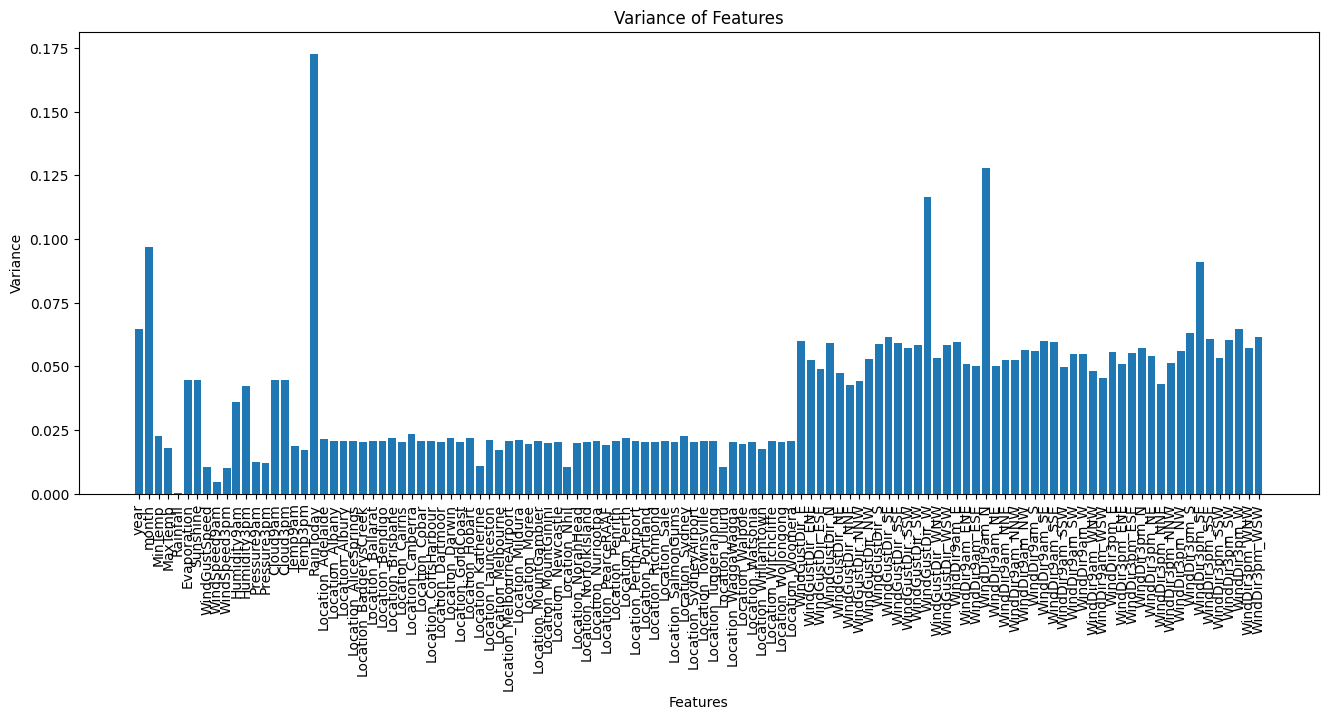

,year,month,MinTemp,MaxTemp,Evaporation,Sunshine,WindGustSpeed,WindSpeed3pm,Humidity9am,Humidity3pm,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
40012,0.3,0.272727,0.511792,0.570888,0.458035,0.458035,0.186047,0.195402,0.79,0.63,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41742,0.8,0.272727,0.504717,0.510397,0.458035,0.458035,0.240310,0.229885,0.69,0.52,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
109832,0.5,0.454545,0.370283,0.391304,0.458035,0.458035,0.263236,0.103448,0.74,0.67,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21977,0.4,0.454545,0.528302,0.480151,0.458035,0.458035,0.186047,0.218391,0.80,0.73,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86464,0.8,0.454545,0.436321,0.489603,0.458035,0.458035,0.108527,0.080460,0.63,0.46,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# Variance of each feature
variance_values = np.var(X_train, axis=0)

# Plot
plt.figure(figsize=(16, 6))
plt.bar(X_train.columns, variance_values)
plt.title('Variance of Features')
plt.xlabel('Features')
plt.ylabel('Variance')
plt.xticks(rotation='vertical')
plt.show()

# Threshold
threshold = 0.01

# Use VarianceThreshold to select features based on the threshold
selector = VarianceThreshold(threshold)

X_train_modified = selector.fit_transform(X_train)

selected_indices = selector.get_support(indices=True)
selected_feature_names = X_train.columns[selected_indices]
X_train = X_train[selected_feature_names]
X_test = X_test[selected_feature_names]

X_train.head()

A correlation matrix is constructed to study the linear relationships between the features and the target feature, as well as the linear relationships among predictor features. Features with a low correlation coefficient (<0.20) with respect to the target feature (RainTomorrow) are removed.

In [16]:
X_train_modified = X_train.copy()
X_test_modified = X_test.copy()
X_train_modified["RainTomorrow"] = y_train

train_data_correlation = X_train_modified.copy()

# Calculate the correlation matrix
correlation_matrix = train_data_correlation.corr()

# Correlation coefficients with the target feature
correlations = train_data_correlation.corrwith(train_data_correlation['RainTomorrow']).drop('RainTomorrow')

# Threshold for correlation coefficients
threshold = 0.20

# Identify features to drop based on the correlation threshold
features_to_drop = correlations[abs(correlations) < threshold].index

train_data = X_train_modified.drop(columns=features_to_drop)

test_data = X_test_modified.drop(columns=features_to_drop)
test_data["RainTomorrow"] = y_test

In [19]:
X_train = train_data
X_test = test_data
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

X_train.head(5)

,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,RainToday,RainTomorrow
0,0.186047,0.79,0.63,0.738843,0.713344,0.0,0.0
1,0.240310,0.69,0.52,0.702479,0.708402,0.0,0.0
2,0.263236,0.74,0.67,0.520661,0.499176,1.0,1.0
3,0.186047,0.80,0.73,0.652893,0.642504,0.0,0.0
4,0.108527,0.63,0.46,0.743802,0.742998,0.0,0.0


In [20]:
X_test.head(5)

,WindGustSpeed,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,RainToday,RainTomorrow
0,0.271318,1.00,0.98,0.350413,0.448105,1.0,1.0
1,0.325581,0.73,0.73,0.778512,0.751236,0.0,0.0
2,0.356589,0.45,0.25,0.819835,0.785832,0.0,0.0
3,0.294574,0.48,0.40,0.540496,0.520593,0.0,0.0
4,0.511628,0.89,0.25,0.433058,0.375618,0.0,1.0


## Model Building, Training, and Testing:

The training and test datasets are constructed from their respective DataFrames. Next, the training set is divided into two subsets: one for training and one for validation.

In [21]:
batch_size = 64

# Set a seed for reproducibility
torch.manual_seed(10)
input_size = X_train.shape[1]

original_X_test = X_test.copy()

target_train = pd.DataFrame(X_train['RainTomorrow'])
del X_train['RainTomorrow']

target_test = pd.DataFrame(X_test['RainTomorrow'])
del X_test['RainTomorrow']

array_target_train = np.array(target_train).astype(int).flatten()
array_target_test = np.array(target_test).astype(int).flatten()
print(array_target_train)

# Convert DataFrame to a PyTorch TensorDataset
train_dataset = data_utils.TensorDataset(torch.Tensor(np.array(X_train)), torch.Tensor(array_target_train).type(torch.LongTensor))

# Split the training set into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
training_data, validation_data = torch.utils.data.random_split(train_dataset, [train_size, val_size], generator=torch.Generator().manual_seed(42))
print(train_dataset)

test_dataset = data_utils.TensorDataset(torch.Tensor(np.array(X_test)), torch.Tensor(array_target_test).type(torch.LongTensor))

[0 0 1 ... 1 1 0]


The training, test, and validation dataloaders are constructed from their respective datasets.

In [22]:
# Create Dataloaders
train_dataloader = data_utils.DataLoader(training_data, batch_size=batch_size, drop_last=False, shuffle=True)
validation_dataloader = data_utils.DataLoader(validation_data, batch_size=batch_size, drop_last=False, shuffle=False)
test_dataloader = data_utils.DataLoader(test_dataset, batch_size=1, drop_last=False, shuffle=True)

Definition of the NeuralNetwork class. In this case, the class constructor takes as parameters the input size, learning rate, dropout rate, number of hidden layers, and the number of neurons per layer. These parameters are included in the class constructor to study the optimal architecture for the neural network. The activation function used is ReLU, while the output layer uses the Softmax function.

In [23]:
# Class Neural Network
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout):
        super().__init__()
        self.flatten = nn.Flatten()
        layers = []
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.ReLU())
        layers.append(nn.Dropout(dropout))
        for layer in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout))
        layers.append(nn.Linear(hidden_size, 2))
        layers.append(nn.Softmax(dim=1))
        self.layer_stack = nn.Sequential(*layers)

    def forward(self, x):
        x = self.flatten(x)
        pred = self.layer_stack(x)
        return pred

Definition of the training function.

In [24]:
def train(dataloader, model, loss_fn, optimizer, print_loss):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        pred = model(X)
        loss = loss_fn(pred, y)
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            if print_loss:
              print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

Definition of the testing function.

In [25]:
def test(dataloader, model, loss_fn, print_AccuracyAndAvgLoss):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss = test_loss / num_batches
    correct = correct / size
    if print_AccuracyAndAvgLoss:
      print(f"Test Error: \n Accuracy: {(100*correct)}%, Avg loss: {test_loss} \n")
    return (100*correct), test_loss

The possible values of the hyperparameters are defined. For each possible combination, a model is built and tested with the validation set.

Maximum accuracy: 77.8559184211683


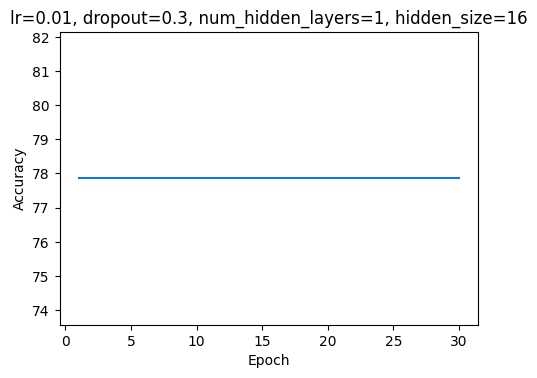

Maximum accuracy: 77.8559184211683


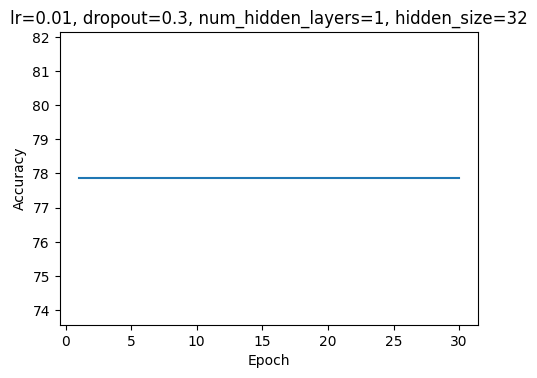

Maximum accuracy: 83.02052657026064


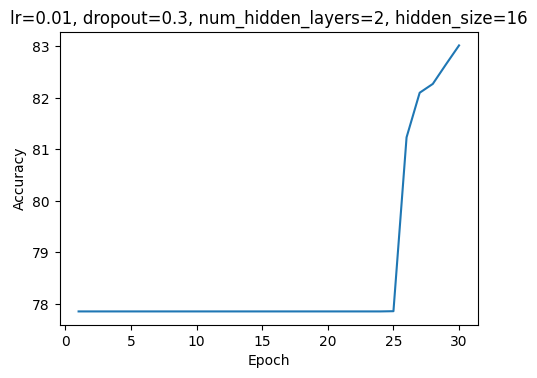

Maximum accuracy: 77.8559184211683


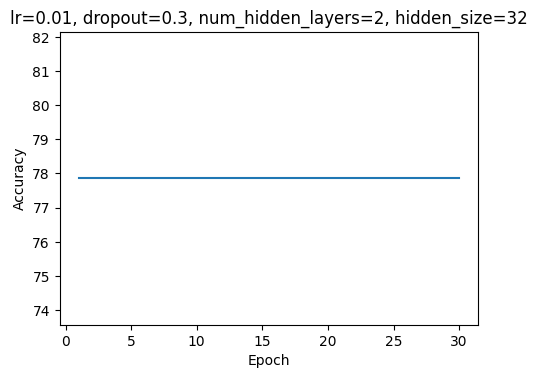

Maximum accuracy: 83.05568985978638


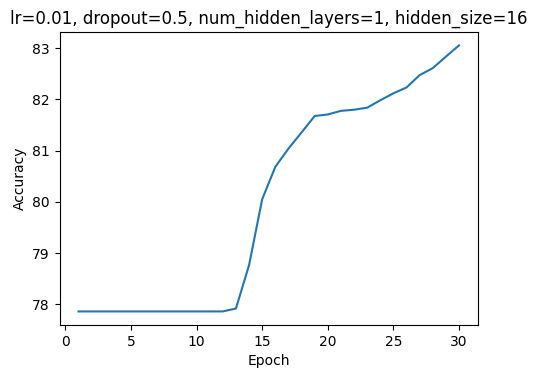

Maximum accuracy: 83.31501912003868


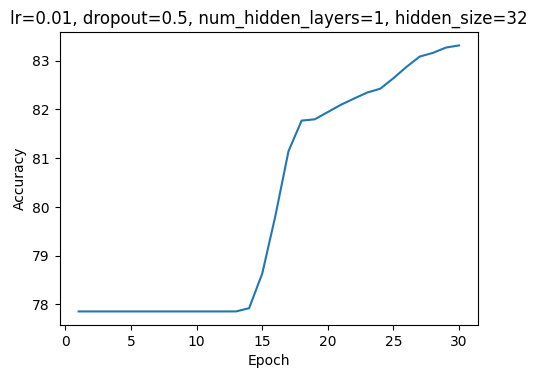

Maximum accuracy: 77.8559184211683


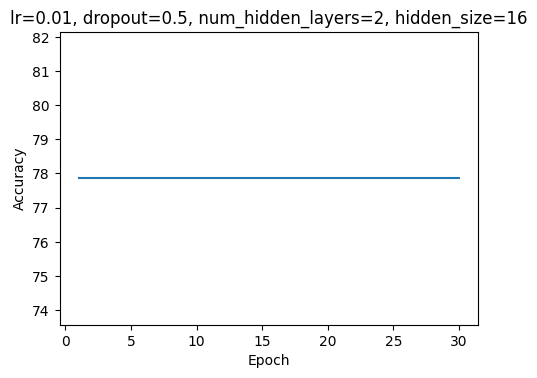

Maximum accuracy: 82.33923783569954


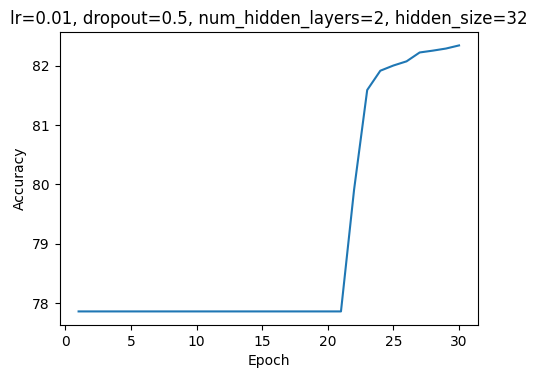

Maximum accuracy: 84.07982066722342


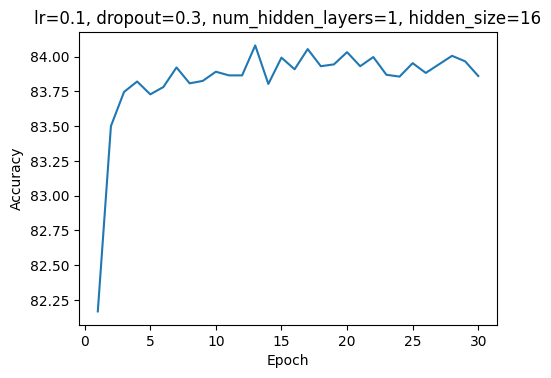

Maximum accuracy: 84.04465737769769


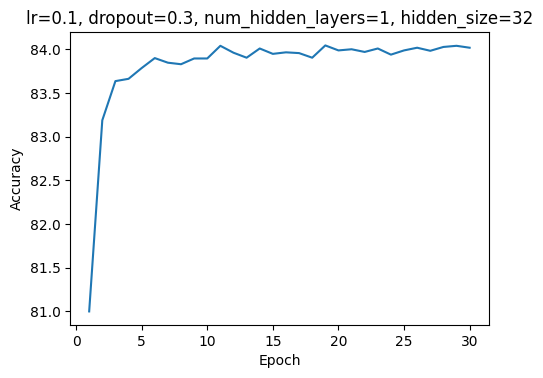

Maximum accuracy: 84.20728759175421


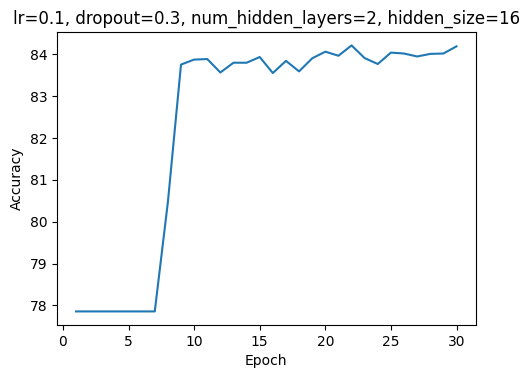

Maximum accuracy: 84.00509867698122


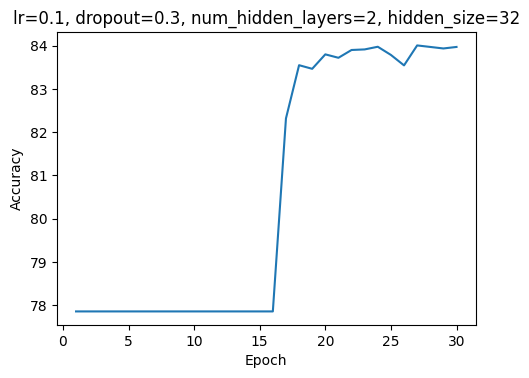

Maximum accuracy: 84.00509867698122


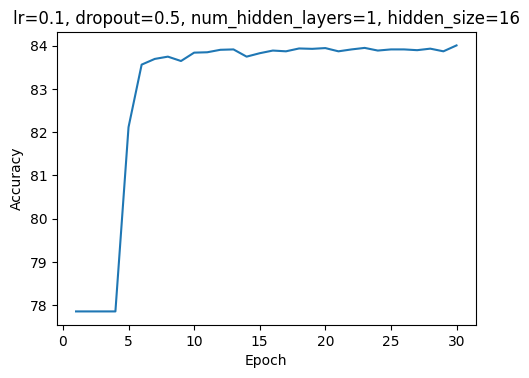

Maximum accuracy: 84.08861148960484


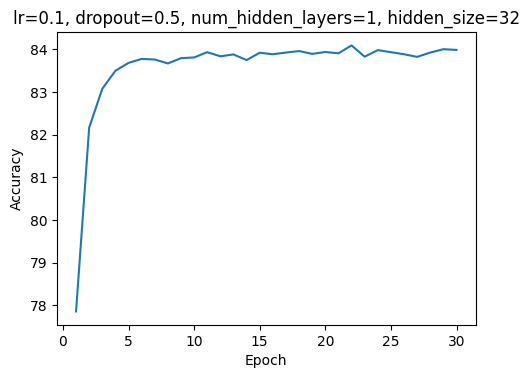

Maximum accuracy: 84.11937936793987


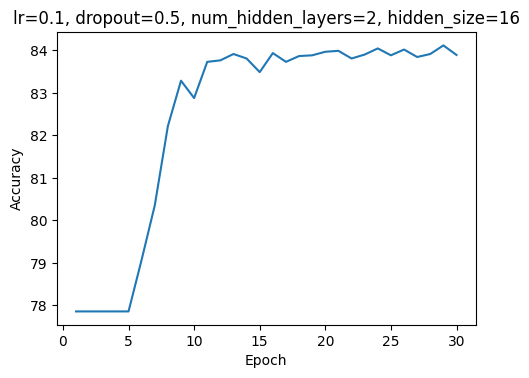

Maximum accuracy: 84.08861148960484


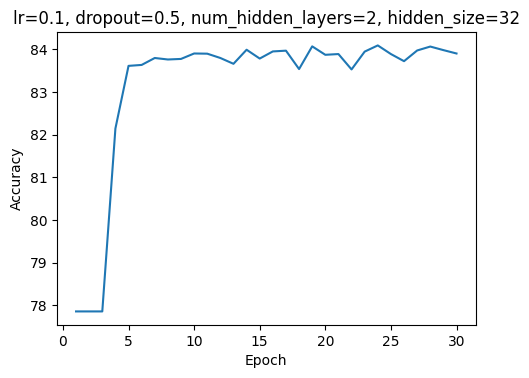

Maximum accuracy for each combination: [77.8559184211683, 77.8559184211683, 83.02052657026064, 77.8559184211683, 83.05568985978638, 83.31501912003868, 77.8559184211683, 82.33923783569954, 84.07982066722342, 84.04465737769769, 84.20728759175421, 84.00509867698122, 84.00509867698122, 84.08861148960484, 84.11937936793987, 84.08861148960484]


In [26]:
# Hyperparameters to test
learning_rates = [0.01, 0.1]
dropouts = [0.3, 0.5]
num_hidden_layers = [1, 2]
hidden_layer_sizes = [16, 32]

combinations = len(learning_rates) * len(dropouts) * len(num_hidden_layers) * len(hidden_layer_sizes)
max_accuracies = []

for lr in learning_rates:
    for dropout in dropouts:
        for num_layers in num_hidden_layers:
            for hidden_size in hidden_layer_sizes:
                model = NeuralNetwork(input_size=6, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
                loss_fn = nn.CrossEntropyLoss()
                optimizer = torch.optim.SGD(model.parameters(), lr=lr)

                epochs = 30
                accuracies = []
                for epoch in range(epochs):
                    train(train_dataloader, model, loss_fn, optimizer, False)
                    accuracy, _ = test(validation_dataloader, model, loss_fn, False)
                    accuracies.append(accuracy)
                max_accuracy = max(accuracies)
                max_accuracies.append(max_accuracy)
                print(f"Maximum accuracy: {max_accuracy}")

                # Plot accuracy per epoch
                plt.figure(figsize=(5.4, 3.8))
                plt.plot(range(1, epochs + 1), accuracies)
                plt.xlabel('Epoch')
                plt.ylabel('Accuracy')
                plt.title(f'lr={lr}, dropout={dropout}, num_hidden_layers={num_layers}, hidden_size={hidden_size}')
                plt.show()

print("Maximum accuracy for each combination:", max_accuracies)

Based on the results obtained, a model is built using the following combination of hyperparameters:

*   Learning rate: 0.1
*   Dropout: 0.3
*   Num hidden layers: 2
*   Hidden layers size: 16


In [27]:
# Model definition
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(6, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 16),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(16, 2),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        x = self.flatten(x)
        pred = self.linear_relu_stack(x)
        return pred

Stochastic Gradient Descent (SGD) is used, which adjusts the model parameters (weights and biases) in each iteration by calculating the gradient over mini-batches of size 64.

The loss function used is Cross-Entropy Loss.

In [28]:
model = NeuralNetwork()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)  # Gradient Descent, lr is learning rate

The model is trained for 50 epochs and evaluated using the validation set.

In [29]:
epochs = 50
accuracies = []
losses = []

for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer, False)
print("Done!")

Epoch 1
-------------------------------
Epoch 2
-------------------------------
Epoch 3
-------------------------------
Epoch 4
-------------------------------
Epoch 5
-------------------------------
Epoch 6
-------------------------------
Epoch 7
-------------------------------
Epoch 8
-------------------------------
Epoch 9
-------------------------------
Epoch 10
-------------------------------
Epoch 11
-------------------------------
Epoch 12
-------------------------------
Epoch 13
-------------------------------
Epoch 14
-------------------------------
Epoch 15
-------------------------------
Epoch 16
-------------------------------
Epoch 17
-------------------------------
Epoch 18
-------------------------------
Epoch 19
-------------------------------
Epoch 20
-------------------------------
Epoch 21
-------------------------------
Epoch 22
-------------------------------
Epoch 23
-------------------------------
Epoch 24
-------------------------------
Epoch 25
----------------

The model is evaluated using the test set (test_dataloader).

In [ ]:
model.eval()
y_true = []
y_pred = []
with torch.no_grad():
    for X, y in test_dataloader:
        y_true.append(y.item())
        pred = model(X)
        y_pred.append(pred.argmax(1).item())

In [ ]:
metrics_report = metrics.classification_report(y_true, y_pred)
print(metrics_report)

              precision    recall  f1-score   support

           0       0.85      0.96      0.90     22098
           1       0.72      0.40      0.52      6341

    accuracy                           0.83     28439
   macro avg       0.79      0.68      0.71     28439
weighted avg       0.82      0.83      0.81     28439

